In [1]:
import h5py
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt

In [2]:
fpaths = ['/gscratch/jisao/mclaret/GL64/Juin_Juillet/ik1_Rb_0p8_Rmin_2dx/',
          '/gscratch/jisao/mclaret/GL64/Juin_Juillet/ik58_Rb_0p8_Rmin_2dx/',
          '/gscratch/jisao/mclaret/GL64/Juin_Juillet/ik89_Rb_0p8_Rmin_2dx/']
depths = ['surface', '500m', '1500m']
tracks_full = {depth:[] for depth in depths}  # dictionary for tracks at each depth

for i,fpath in enumerate(fpaths):
    # go through each eddy file
    f = h5py.File(fpath + 'eddy_tracks.mat')

    # Arrange data into a list of dictionaries
    data = f['tracks']            # relevant variables
    varnames = list(f['tracks'])  # variable names
    ntracks = len(data['x1'])     # number of tracks (should match with length of data in 'x1')

    tracks = []
    # add dictionaries for each variable to the corresponding eddy index (0 - N-1)
    for itrack in range(ntracks):
        variables = {var:[] for var in varnames}  # initialize a dictionary with each variable name
        for var in varnames:
            # go through each variable
            if var[0:6] == 'shapes':
                # translate shapes data to list of numpy arrays (one array for each time step)
                coordinates = []                             # initialize list of coordinates
                numSteps = len(f[data[var][itrack,0]][(0)])  # number of timesteps
                # each timestep has its own hdf5 object reference, so append each step to a list
                for step in range(numSteps):
                    coords = np.array(f[f[data[var][itrack,0]][(0, step)]])
                    coordinates.append(coords)
                variables[var] = coordinates
            else:
                # translate data from hdf5 object reference to numpy array
                variables[var] = np.array(f[data[var][itrack,0]][(0)])
        tracks.append(variables)
    tracks_full[depths[i]] = tracks
    
print('Number of depths:', len(tracks_full))

Number of depths: 3


In [3]:
lifetime = 0                                   # lifetime filter (in hours)
cyclones = {depth:[] for depth in depths}      # dictionary of cyclonic eddies at each depth
anticyclones = {depth:[] for depth in depths}  # dictionary of anticyclonic eddies at each depth

for depth in depths:
    tracks = tracks_full[depth]
    cTracks = []
    aTracks = []
    for i, track in enumerate(tracks):
        timesteps = track['step'][-1] - track['step'][0]+1
        if timesteps >= lifetime and track['type'][0] == 1.:
            # add to list of cyclonic eddies
            cTracks.append(track)
        if timesteps >= lifetime and track['type'][0] == -1.:
            # add to list of cyclonic eddies
            aTracks.append(track)
    cyclones[depth] = cTracks
    anticyclones[depth] = aTracks

print('Num Eddies')
for depth in depths:
    print(f'{depth:9}a: {len(anticyclones[depth])}  c: {len(cyclones[depth])}')

Num Eddies
surface  a: 313  c: 425
500m     a: 115  c: 101
1500m    a: 104  c: 112


In [4]:
from scipy.io import netcdf
grids = ['GLazur64-T20_y2009m0607_gridU_ik1.nc',
        'GLazur64-T20_y2009m0607_gridV_ik1.nc',
        'GLazur64-T20_y2009m0607_gridU_ik58.nc',
        'GLazur64-T20_y2009m0607_gridV_ik58.nc',
        'GLazur64-T20_y2009m0607_gridU_ik89.nc',
        'GLazur64-T20_y2009m0607_gridV_ik89.nc']
gridU = {depth:[] for depth in depths}  # zonal velocities at each depth
gridV = {depth:[] for depth in depths}  # meridional velocities at each depth
j = 0
for i,depth in enumerate(depths):
    gridU[depth] = netcdf.netcdf_file(fpaths[i] + grids[j],'r')
    gridV[depth] = netcdf.netcdf_file(fpaths[i] + grids[j+1],'r')
    j += 2

In [5]:
def fillCoords(trackSteps, trackLons, trackLats, fill='midpoint'):
    # fill xs and ys (default fills using the point btwn gaps)
    prev = trackSteps[0]
    steps = np.array([])
    lons = []
    lats = []
    for i, step in enumerate(trackSteps):
        lon = trackLons[i]
        lat = trackLats[i]
        if step - prev > 1:
            # there is a gap
            stepFill = np.arange(prev+1, step, 1.)
            numFill = len(stepFill)
            if fill == 'midpoint':
                # fill using mid-point of gap
                lonFill = np.ones(len(stepFill))*((lon + trackLons[i-1])/2)
                latFill = np.ones(len(stepFill))*((lat + trackLats[i-1])/2)
            elif fill == 'linear':
                # fill with linearly spaced positions between gap
                lonFill = np.linspace(trackLons[i-1], lon, num=numFill)
                latFill = np.linspace(trackLats[i-1], lat, num=numFill)
            elif fill == 'begin':
                # fill with beginning position of gap
                lonFill = np.ones(len(stepFill))*(trackLons[i-1])
                latFill = np.ones(len(stepFill))*(trackLats[i-1])
            elif fill == 'end':
                # fill with end position of gap
                lonFill = np.ones(len(stepFill))*lon
                latFill = np.ones(len(stepFill))*lat
            else:
                raise ValueError('Invalid fill type.')
            steps = np.append(steps, stepFill)
            lons = np.append(lons, lonFill)
            lats = np.append(lats, latFill)
        steps = np.append(steps, step)
        lons = np.append(lons, lon)
        lats = np.append(lats, lat)
        prev = step
    steps.flatten()
    lons.flatten()
    lats.flatten()
    return steps, lons, lats

In [6]:
# keep lowest values along each nav dimension, and verify nav resolution
lowest_lon = gridU['surface'].variables['nav_lon'][0, 0].copy()  # lowest longitude
lowest_lat = gridU['surface'].variables['nav_lat'][0, 0].copy()  # lowest latitude
nav_res = 1./64    # spatial resolution (in degrees)
dt = 1.0           # temporal resolution (in hours)
omega = 7.2921e-5

In [7]:
eddyTypes = ['cyclone', 'anticyclone']             # eddy types
plotVars = ['amps', 'freqs']                       # plot variables
spectra = {eddyType:[] for eddyType in eddyTypes}  # spectra for each eddy type

# loop through cyclones and anticyclones
for eddyType in eddyTypes:
    spectra[eddyType] = {depth:[] for depth in depths}  # spectra for each depth
    for depth in depths:
        spectra[eddyType][depth] = {plotVar:[] for plotVar in plotVars}  # plot variables for each depth
        
        if eddyType == 'cyclone':
            tracks = cyclones[depth]
        else:
            tracks = anticyclones[depth]
        
        n = len(tracks[0]['step'])  # fixed num values for fft
        for track in tracks:
            steps = len(track['step'])
            if steps > n:
                n = steps
        
        fullTimes = np.arange(0, n, dt)
        fq = np.fft.fftfreq(fullTimes.shape[-1],dt)   # frequencies corresponding to each FC (cycles/h)
        
        for track in tracks:
            steps, lons, lats = fillCoords(track['step'], track['x1'], track['y1'], fill='linear')
            maxt = len(steps)  # num steps this eddy is present

            fCor = 2.*omega*np.sin((lats[len(lats)//2])/180*np.pi)  # coriolis frequency (rad/sec)

            # Tapered cosine window
            alpha = 0.2
            win = signal.tukey(maxt, alpha)  # 20% of points

            hvels = []
            for i in range(len(steps)):
                # interpolate U and V at each eddy center
                target_lon = lons[i]  # longitude of eddy center
                target_lat = lats[i]  # latitude of eddy center
                
                lb_lon = int((target_lon - lowest_lon)/nav_res)  # index of lon lower bound
                lb_lat = int((target_lat - lowest_lat)/nav_res)  # index of lat lower bound

                W2lon = (target_lon - lowest_lon)%nav_res  # W2 lon
                W2lat = (target_lat - lowest_lat)%nav_res  # W2 lat

                Us = gridU[depth].variables['vozocrtx'][i, 0, lb_lat:lb_lat+2, lb_lon:lb_lon+2].copy()  # zonal velocities
                Vs = gridV[depth].variables['vomecrty'][i, 0, lb_lat:lb_lat+2, lb_lon:lb_lon+2].copy()  # meridional velocities

                # interpolate for U and V (based on unit square)
                U_target = Us[0,0]*(1-W2lon)*(1-W2lat) + Us[0,1]*W2lon*(1-W2lat) + Us[1,0]*(1-W2lon)*W2lat + Us[1,1]*W2lon*W2lat
                V_target = Vs[0,0]*(1-W2lon)*(1-W2lat) + Vs[0,1]*W2lon*(1-W2lat) + Vs[1,0]*(1-W2lon)*W2lat + Vs[1,1]*W2lon*W2lat

                hvels.append(U_target + 1j*V_target)

            fcs = np.fft.fft(hvels*win, n=n)  # k58 Fourier coefficients (FCs) w/ window and padded to n
            amp = np.abs(fcs)**2
            fq_norm = fq*2*np.pi/fCor/3600
            if track is tracks[0]:
                amps = amp      # preallocate array for amplitudes
                fq_norms = fq_norm   # preallocate array for normalized frequencies
            else:
                amps += amp          # add to amplitudes
                fq_norms += fq_norm  # add to normalized frequencies
        
        nTracks = len(tracks)   # number of tracks
        amps /= nTracks         # average amplitudes
        fq_norms /= nTracks     # average frequencies
        
        # shift for plotting
        spectra[eddyType][depth]['amps'] = np.fft.fftshift(amps)       
        spectra[eddyType][depth]['freqs'] = np.fft.fftshift(fq_norms)

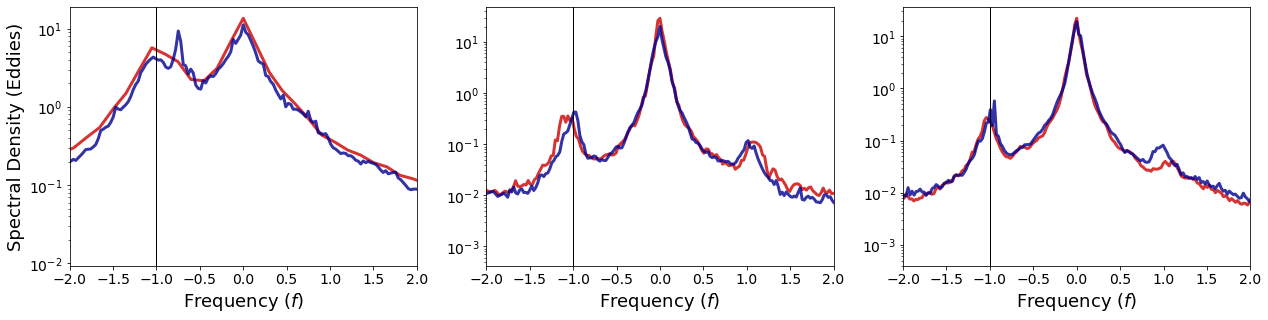

In [49]:
fig = plt.figure(figsize=(21.16,4.77))
red = (1-0.2, 0,0)
blue = (0, 0, 1-0.4353)
i=1
for depth in depths:
    ax = fig.add_subplot(1,3,i)
    ax.plot(spectra['cyclone'][depth]['freqs'], spectra['cyclone'][depth]['amps'],
            color=red, label='cyclones', linewidth=3, alpha=0.8)
    ax.plot(spectra['anticyclone'][depth]['freqs'], spectra['anticyclone'][depth]['amps'],
            color=blue, label='anticyclones', linewidth=3, alpha=0.8)
    
    # Set the font name for axis tick labels
    for tick in ax.get_xticklabels():
        tick.set_fontsize(14)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(14)
    
    ax.set_yscale('log')
    ax.set_xlim(-2,2)
    plt.axvline(x=-1, color='k', linewidth=1)
    ax.set_xlabel('Frequency ($\it{f}$)', fontsize=18)
    #ax.set_title(depth, fontsize=20)
    #plt.legend()
    if i<2:
        ax.set_ylabel('Spectral Density (Eddies)', fontsize=18)
    i+=1

plt.show()
fig_path = './figures/'
fname = 'spectra_eddies.png'
fig.tight_layout()
fig.savefig(fig_path+fname, dpi=80)